In [1]:
from multiprocessing.sharedctypes import Value
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import linalg as la
from scipy.integrate import quad
from scipy.stats import norm
from scipy.integrate import nquad

class GaussianQuadrature:
    """Class for integrating functions on arbitrary intervals using Gaussian
    quadrature with the Legendre polynomials or the Chebyshev polynomials.
    """
    # Problems 1 and 3
    def __init__(self, n, polytype="legendre"):
        """Calculate and store the n points and weights corresponding to the
        specified class of orthogonal polynomial (Problem 3). Also store the
        inverse weight function w(x)^{-1} = 1 / w(x).

        Parameters:
            n (int): Number of points and weights to use in the quadrature.
            polytype (string): The class of orthogonal polynomials to use in
                the quadrature. Must be either 'legendre' or 'chebyshev'.

        Raises:
            ValueError: if polytype is not 'legendre' or 'chebyshev'.
        """
        if polytype != "legendre" and polytype != "chebyshev":
            raise ValueError("label must be either legendre or chebyshev")

        self.num_pts = n       #save the number of points and weights as an attribute
        self.label = polytype     #save the type of points that we are going to use

        if self.label == "legendre":
            f = lambda x: 1 
            self.reciprocal = f         #save the inverse weight function as an attribute

        elif self.label == "chebyshev":
            f = lambda x: np.sqrt(1 - (x**2))
            self.reciprocal = f
        
        self.points, self.weights = self.points_weights(n)   #call our function below to get the points and weights and save as attributes

    # Problem 2
    def points_weights(self, n):
        """Calculate the n points and weights for Gaussian quadrature.

        Parameters:
            n (int): The number of desired points and weights.

        Returns:
            points ((n,) ndarray): The sampling points for the quadrature.
            weights ((n,) ndarray): The weights corresponding to the points.
        """
        if self.label == "legendre":             #define the bks and mew according to the legendre polynomials
            bk = [(k**2) / (4*(k**2) - 1) for k in range(1, n+1)]
            mew = 2
        
        elif self.label == "chebyshev":           #define the bks and mew according to the chebychev polynomials
            bk = [1/4 for k in range(1,n+1)]
            bk[0] = 1/2
            mew = np.pi
        
        bk = np.sqrt(bk)

        jacob = np.zeros((n,n))                   #each ak is equal to zero so we can just make a matrix of zeros to which we will add

        jacob[0, 1] = bk[0]

        for j in range(1, n-1):                   #add the corresponding entry of bk to each entry of the jacobi matrix as defined in the lab file
            jacob[j, j-1] = bk[j-1]
            jacob[j, j+1] = bk[j]

        jacob[n-1, n-2] = bk[n-2]

        vals, vecs = la.eig(jacob)                #get the eigenvalues and eigenvectors of the jacobi
        weights = []
        points = np.array(vals)                   #the eigenvalues are the points we will use in the quadrature
        for vect in vecs.T:
            weights.append(((vect[0])**2) * mew)     #calculate the weights 

        return points, weights





    # Problem 3
    def basic(self, f):
        """Approximate the integral of a f on the interval [-1,1]."""
        f_points = f(self.points)          #evaluate f at the quadrature points
        w_points = self.reciprocal(self.points)     #evaluate our reciprocal function at the quadrature points

        g_points = f_points * w_points              #multiply the two functions together to get our g function

        int_ap = self.weights @ g_points            #take the dot product of the weights with g

        return int_ap

    # Problem 4
    def integrate(self, f, a, b):
        """Approximate the integral of a function on the interval [a,b].

        Parameters:
            f (function): Callable function to integrate.
            a (float): Lower bound of integration.
            b (float): Upper bound of integration.

        Returns:
            (float): Approximate value of the integral.
        """
        h = lambda x: f(((b-a) / 2) * x + ((a+b)/2))   #define h using the change of indices formula

        return ((b-a) / 2) * self.basic(h)          #use our previous function and the final quadrature formula

    # Problem 6.
    def integrate2d(self, f, a1, b1, a2, b2):
        """Approximate the integral of the two-dimensional function f on
        the interval [a1,b1]x[a2,b2].

        Parameters:
            f (function): A function to integrate that takes two parameters.
            a1 (float): Lower bound of integration in the x-dimension.
            b1 (float): Upper bound of integration in the x-dimension.
            a2 (float): Lower bound of integration in the y-dimension.
            b2 (float): Upper bound of integration in the y-dimension.

        Returns:
            (float): Approximate value of the integral.
        """
        h = lambda x, y: f(((b1-a1) / 2) * x + ((a1+b1)/2), ((b2-a2) / 2) * y + ((a2+b2)/2))     #define h so that we may integrate over any bounds
        g = lambda x, y: h(x,y) * self.reciprocal(x) * self.reciprocal(y)                        #define g using h and our weights

        int_val = 0

        for i in range(self.num_pts):                                #calculate the sum using the 2-D quadrature formula
            for j in range(self.num_pts):
                int_val += self.weights[i] * self.weights[j] * g(self.points[i], self.points[j])

        return int_val * (b1 - a1) * (b2 - a2) / 4                #multiply by the constant in the formula before returning

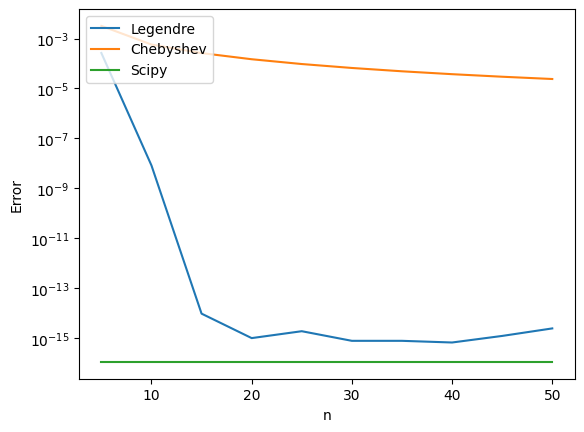

In [2]:
# Problem 5
def prob5():
    """Use scipy.stats to calculate the "exact" value F of the integral of
    f(x) = (1/sqrt(2 pi))e^((-x^2)/2) from -3 to 2. Then repeat the following
    experiment for n = 5, 10, 15, ..., 50.
        1. Use the GaussianQuadrature class with the Legendre polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
        2. Use the GaussianQuadrature class with the Chebyshev polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
    Plot the errors against the number of points and weights n, using a log
    scale for the y-axis. Finally, plot a horizontal line showing the error of
    scipy.integrate.quad() (which doesn’t depend on n).
    """
    act_int = norm.cdf(2) - norm.cdf(-3)            #use scipy to calculate the exact value of the integral
    l_errors = []                                    
    c_errors = []
    f = lambda x: (1 / (np.sqrt(2*np.pi))) * np.exp(-1 * (x**2) / 2)          #define our function
    scipy_err = np.abs(act_int - quad(f, -3, 2)[0])                           #calculate the error of the scipy quad 

    ns = np.arange(1, 11) * 5
    scip = np.ones_like(ns) * scipy_err                                       #make the horizontal line representing scipy quad error
    for n in ns:
        leg = GaussianQuadrature(n, "legendre")
        cheb = GaussianQuadrature(n, "chebyshev")

        l_errors.append(np.abs(act_int - leg.integrate(f, -3, 2)))            #calculate the error of the quadrature of each type with each number of points
        c_errors.append(np.abs(act_int - cheb.integrate(f, -3, 2)))

    plt.plot(ns, l_errors, label="Legendre")                         #plot and make sure that y is a logarithmic scale
    plt.plot(ns, c_errors, label="Chebyshev")
    plt.plot(ns, scip, label="Scipy")
    plt.xlabel("n")
    plt.ylabel("Error")
    plt.legend(loc="upper left")
    plt.yscale("log")
    plt.show()
prob5()